# From the lab3 solution:

1D Ising spin lattice
--------------------
Number of spins: 100
Temperature: 1.0  J/k_B
Magnetisation: 100
Energy: -299.0  J


KeyboardInterrupt: 

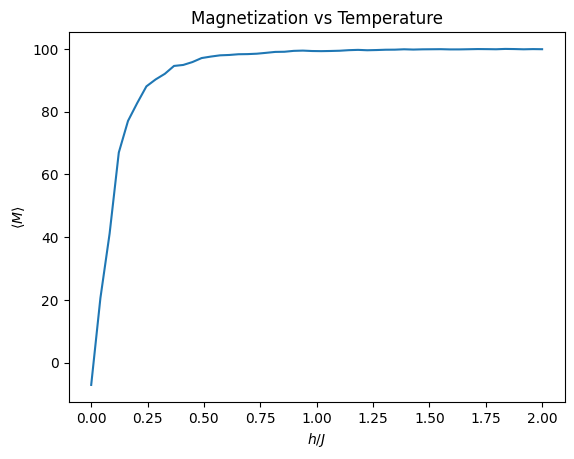

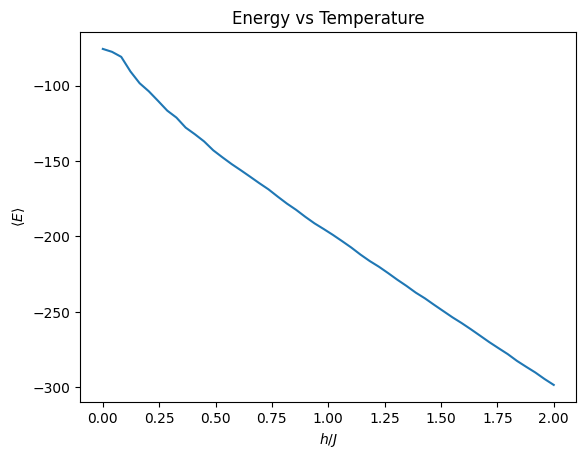

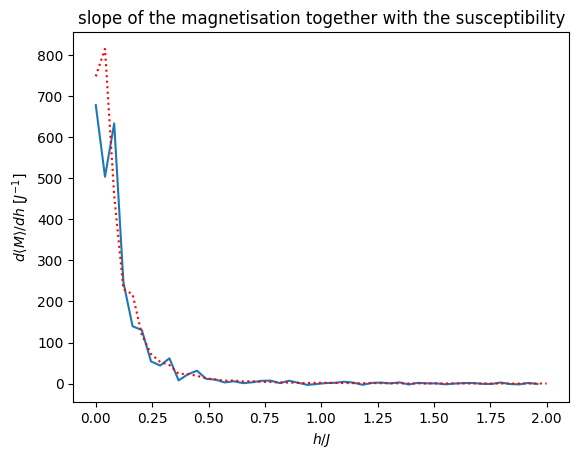

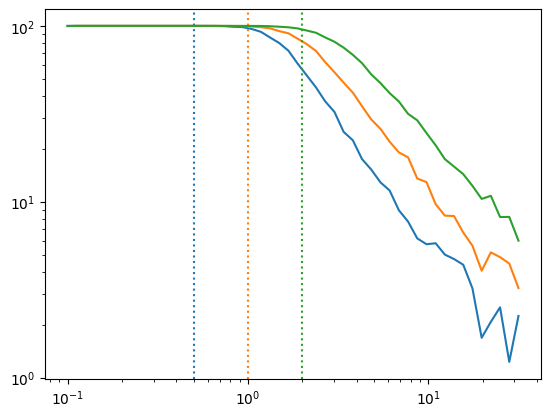

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

class IsingModel1D:
    # Initializes the 1D Ising model.
    def __init__(self, N, T, h, state = None):
        self.N = N  # Number of spins
        self.temp = T  # Temperature
        self.field = h
        if state is None:
            # Initialize spins randomly if no initial state is given
            self.spins = np.random.choice([-1, 1], size=N)  
        else:
            self.spins = state

    #Calculates the energy of the current spin configuration
    #The energy is calculated based on the interaction between neighboring spins and the external magnetic field.
    def energy(self):
        """Calculate the energy of the current spin configuration."""
        return -np.sum(self.spins[:-1] * self.spins[1:]) - self.field*self.magnetization()

    #Performs one Metropolis step to update the spin configuration
    #sweep: Determines the order of spin updates ('random' or 'sequential').
    #For each spin, the change in energy (delta_E) is calculated if the spin is flipped. The spin is flipped with a probability based on the Metropolis criterion.
    def metropolis_step(self, sweep = 'random'):
        """Perform one Metropolis step."""
        for j in range(self.N):
            if sweep == 'random':
                i = np.random.randint(0, self.N)  # Choose a random spin
            elif sweep == 'sequential':
                i = j
            delta_E = 2 * self.spins[i] * (self.spins[i-1] + self.spins[(i+1) % self.N]) + 2*self.field*self.spins[i]  # Energy change if this spin is flipped
            if delta_E < 0 or np.random.rand() < np.exp(-delta_E / self.temp):
                self.spins[i] *= -1  # Flip the spin

    def print_info(self):
        print('1D Ising spin lattice')
        print('-'*20)
        print('Number of spins:', self.N)
        print('Temperature:', self.temp, ' J/k_B')
        print('Magnetisation:', self.magnetization())
        print('Energy:', self.energy(), ' J')        

    #Simulates the Ising model for a given number of steps.
    #steps: Number of Metropolis steps to perform.
    #init_steps: Number of initial steps to equilibrate the system.
    #sweep: Determines the order of spin updates ('random' or 'sequential').
    def simulate(self, steps = 500, init_steps = 100, sweep = 'random'):
        """Simulate the Ising model for a given number of steps."""
        # Initialise the lattice 
        for _ in range(init_steps):
            self.metropolis_step(sweep)
        # Perform metropolis steps and average observables
        M, E, M_var = 0, 0, 0
        for _ in range(steps):
            self.metropolis_step()
            M += self.magnetization()
            M_var += self.magnetization()**2
            E += self.energy()
        E = E/steps
        M = M/steps
        M_var = M_var/steps - M**2
        return M, E, M_var, self.spins

    def magnetization(self):
        """Calculate the magnetization of the current spin configuration."""
        return np.sum(self.spins)

total_time = time()

N = 100  # Number of spins
temp = 1.0  # Temperature
hs = np.linspace(0,2,50)

# ###### RANDOM UPDATING ######

# Compute average magnetisation and energy as a function of the magnetic field
Ms, Es, chis = [], [], []
state = np.random.choice([-1,1], size = N)
for h in hs:
    ising_model = IsingModel1D(N, temp, h)
    M, E, M_var, _ = ising_model.simulate()
    Ms.append(M)
    Es.append(E)
    chis.append(M_var/temp)
# Print the information about the lattice    
ising_model.print_info()

# Plot the magnetisation as a function of external magnetic field,
# demonstrating paramagnetic behaviour at low field and saturation at large field
fig, ax = plt.subplots()
ax.plot(hs, Ms)
ax.set_title('Magnetization vs Temperature')
ax.set_xlabel('$h/J$')
ax.set_ylabel('$\\langle M \\rangle$')

# Plot the energy as a function of magnetic field, showing near-linear decrease for large field
fig, ax = plt.subplots()
ax.plot(hs, Es)
ax.set_title('Energy vs Temperature')
ax.set_xlabel('$h/J$')
ax.set_ylabel('$\\langle E \\rangle$')

# Plot the slope of the magnetisation together with the susceptibility
fig, ax = plt.subplots()
dh = hs[1]-hs[0]
dMdh = np.diff(Ms)/dh
ax.plot(hs[:-1], dMdh)
ax.plot(hs, chis, 'r:')
ax.set_title('slope of the magnetisation together with the susceptibility')
ax.set_xlabel('$h/J$')
ax.set_ylabel('$d\\langle M\\rangle/dh$ $[J^{-1}]$')


# Compute average magnetisation as a function of temperature for various fields
# Use the final state of the last run as the initial state of the next run, allowing us to skip the initialisation steps
# Plot on logarithmic scale to show Curie's law 
# Show the value where k_B T = h as a vertical dashed line
hs = [0.5, 1.0, 2.0, 3.0]
Ts = np.logspace(-1.0,1.5, 50)
spins = np.ones(N)
fig, ax = plt.subplots()
for h in hs:
    Ms = []
    for temp in Ts:
        ising_model = IsingModel1D(N, temp, h, state = spins)
        M, E, M_var, spins = ising_model.simulate(init_steps = 0)
        Ms.append(M)
    line, = ax.loglog(Ts, Ms, label = ['h = '+str(h)+'J'])
    ax.axvline(x=h, color = line.get_color(), linestyle = ':')
ax.set_title('slope of the magnetisation together with the susceptibility')
ax.set_xlabel('$k_BT/J$')
ax.set_ylabel('$\\langle M\\rangle$')
ax.legend()


###### SEQUENTIAL VS. RANDOM UPDATING ######

# Parameters
N, T, h = 400, 2.0, 2.0
n_steps, dn = 400, 1

# List of possible values for the total number of steps/sweeps
steps_list = np.arange(dn,n_steps,dn)


# Check for convergence using random updating
ising_lattice = IsingModel1D(N, T, h, state = np.random.choice([-1,1], N))
Ms_random = []
for i in range(len(steps_list)):
    M , _ , _ , _ = ising_lattice.simulate(steps = dn, init_steps = 0)
    Ms_random.append(M)

# Check for convergence using sequential updating
ising_lattice = IsingModel1D(N, T, h, state =  np.random.choice([-1,1], N))
Ms_sequential = []
for i in range(len(steps_list)):
    M , _ , _ , _ = ising_lattice.simulate(steps = dn, init_steps = 0, sweep = 'sequential')
    Ms_sequential.append(M)

# Find the corresponding averages by adding up the values and dividing by the number of steps
Ms_random = np.cumsum(Ms_random)/steps_list/N
Ms_sequential = np.cumsum(Ms_sequential)/steps_list/N

# Compare the two sets of results 
fig, ax = plt.subplots()
ax.plot(steps_list, Ms_random)
ax.plot(steps_list, Ms_sequential, 'r:')
ax.set_title('Sequential MS vs steps MS')
ax.set_xlabel('number of steps')
ax.set_ylabel('$\\langle M\\rangle$')

# Report total simulation time
total_time = time()-total_time
print('Total simulation time: ', total_time, 's')


# Copilot -- 

**Prompt:**

Think like a a quantum physicist. Generate a Python class to simulate the 2D Ising model on a square lattice using the Metropolis Monte Carlo algorithm. Add a plot of the average magnetisation, energy , magnetic susceptibility, heat capacity C as a function of the magnetic field h for a system of size LxL = 10 and two dierent temperatures: k_BT/J = 1.0, k_BT/J = 4.0. Plot the same quantities as a function of temperature for h = 0 . Find the critical temperature T_c of the phase transition between ferromagnetic and paramagnetic phases. Plot the magnetic susceptibility and the heat capacity as a function of system size T = T_c at in order to extract the critical exponents. Ensure there are comments explaining eacch bit of the code, and connecting it to the phyics

In [9]:
#step one -- import necessary libraries -- microsoft copilot
import numpy as np
import matplotlib.pyplot as plt

#step 2 -- Define the Ising Model Class
class IsingModel:
    def __init__(self, L, T, J=1, h=0):
        self.L = L  # Lattice size
        self.T = T  # Temperature
        self.J = J  # Interaction strength
        self.h = h  # External magnetic field
        self.lattice = np.random.choice([-1, 1], size=(L, L))  # Initialize lattice with random spins

    def energy(self):
        """Calculate the total energy of the current lattice configuration."""
        E = 0
        for i in range(self.L):
            for j in range(self.L):
                S = self.lattice[i, j]
                neighbors = self.lattice[(i+1)%self.L, j] + self.lattice[i, (j+1)%self.L] + \
                            self.lattice[(i-1)%self.L, j] + self.lattice[i, (j-1)%self.L]
                E += -self.J * S * neighbors - self.h * S
        return E / 4  # Each pair counted twice

    def magnetization(self):
        """Calculate the total magnetization of the current lattice configuration."""
        return np.sum(self.lattice)

    def metropolis_step(self):
        """Perform one Metropolis step."""
        for _ in range(self.L**2):
            i = np.random.randint(0, self.L)
            j = np.random.randint(0, self.L)
            S = self.lattice[i, j]
            neighbors = self.lattice[(i+1)%self.L, j] + self.lattice[i, (j+1)%self.L] + \
                        self.lattice[(i-1)%self.L, j] + self.lattice[i, (j-1)%self.L]
            dE = 2 * S * (self.J * neighbors + self.h)
            if dE < 0 or np.random.rand() < np.exp(-dE / self.T):
                self.lattice[i, j] *= -1

    def simulate(self, steps):
        """Simulate the Ising model for a given number of steps."""
        energies = []
        magnetizations = []
        for _ in range(steps):
            self.metropolis_step()
            energies.append(self.energy())
            magnetizations.append(self.magnetization())
        return np.array(energies), np.array(magnetizations)

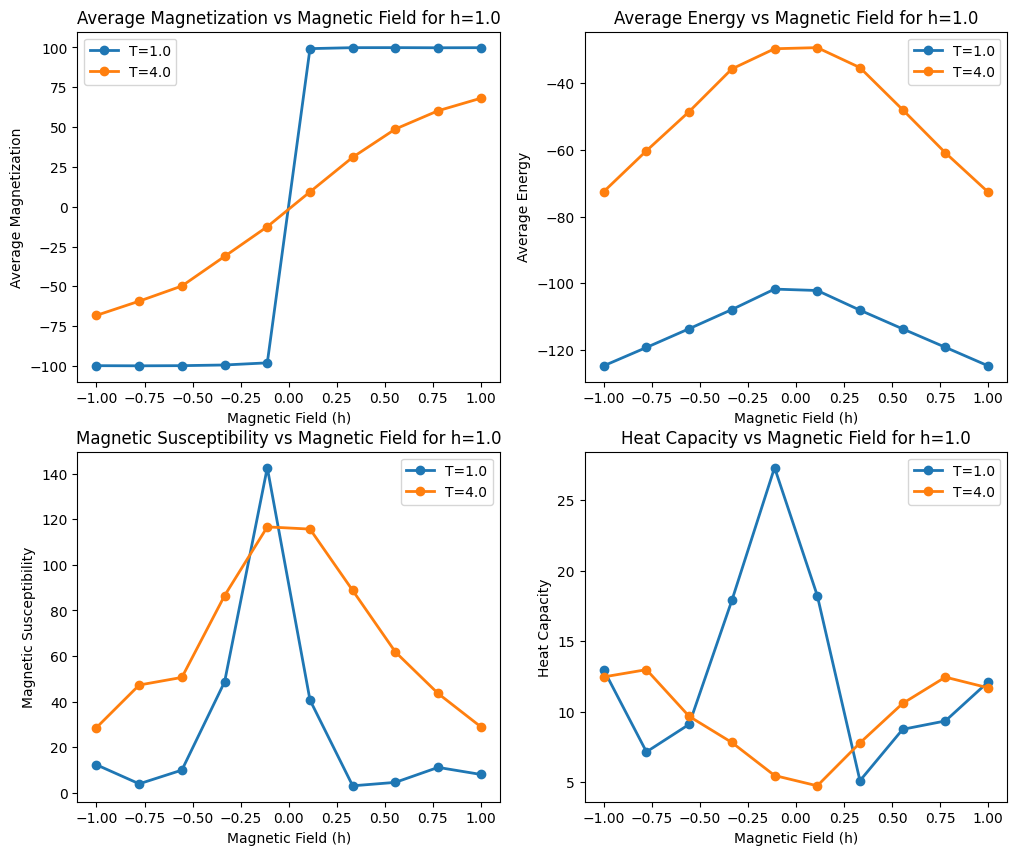

In [5]:
#Fixing the 3rd step -- Simulate and Plot Results

def plot_results(L, T_values, h_values, steps):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for T in T_values:
        avg_magnetizations = []
        avg_energies = []
        susceptibilities = []
        heat_capacities = []
        
        for h in h_values:
            model = IsingModel(L, T, h=h)
    
            energies, magnetizations = model.simulate(steps)
            avg_magnetizations.append(np.mean(magnetizations))
            avg_energies.append(np.mean(energies))
            susceptibilities.append(np.var(magnetizations) / T)
            heat_capacities.append(np.var(energies) / (T**2))

        # Plot the accumulated results 
        """Here i placed the plots outside the loop, which allowed for joint curves."""
        axs[0, 0].plot(h_values, avg_magnetizations, '-o', linewidth=2, label=f'T={T}')
        axs[0, 1].plot(h_values, avg_energies, '-o', linewidth=2, label=f'T={T}')
        axs[1, 0].plot(h_values, susceptibilities, '-o', linewidth=2, label=f'T={T}')
        axs[1, 1].plot(h_values, heat_capacities, '-o', linewidth=2, label=f'T={T}')

    axs[0, 0].set_title(f'Average Magnetization vs Magnetic Field for h={h}')
    axs[0, 1].set_title(f'Average Energy vs Magnetic Field for h={h}')
    axs[1, 0].set_title(f'Magnetic Susceptibility vs Magnetic Field for h={h}')
    axs[1, 1].set_title(f'Heat Capacity vs Magnetic Field for h={h}')
                        
    axs[0,0].set_ylabel('Average Magnetization')
    axs[0, 1].set_ylabel('Average Energy')
    axs[1, 0].set_ylabel('Magnetic Susceptibility')
    axs[1, 1].set_ylabel('Heat Capacity')
           
    
    for ax in axs.flat:
        ax.set_xlabel('Magnetic Field (h)')
        ax.legend()

    plt.show()

# Parameters
L = 10
T_values = [1.0, 4.0]
h_values = np.linspace(-1, 1, 10)
steps = 1000

plot_results(L, T_values, h_values, steps)

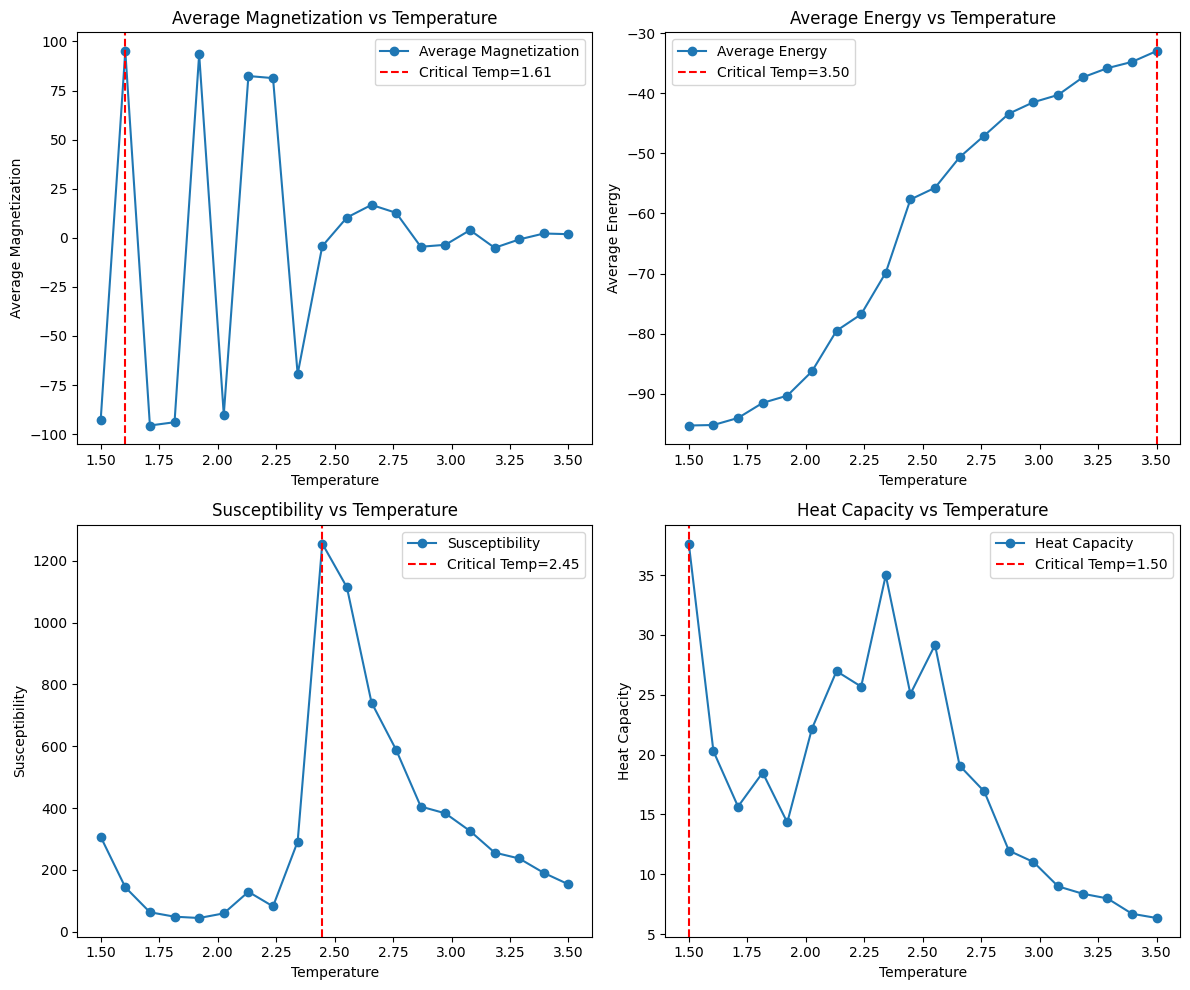

In [12]:
# Critical Temperature and Critical Exponents

def find_critical_temperature(L, T_range, steps):
    temperatures = []

    avg_magnetizations = []
    avg_energies = []
    susceptibilities = []
    heat_capacities = []
    
    crit_temps = []

    for T in T_range:
        model = IsingModel(L, T)

        temperatures.append(T)
        
        energies, magnetizations = model.simulate(steps)
        
        avg_magnetizations.append(np.mean(magnetizations))
        avg_energies.append(np.mean(energies))
        susceptibilities.append(np.var(magnetizations) / T)
        heat_capacities.append(np.var(energies) / (T**2))

    crit_temps.append(temperatures[np.argmax(avg_magnetizations)])
    crit_temps.append(temperatures[np.argmax(avg_energies)])
    crit_temps.append(temperatures[np.argmax(susceptibilities)])
    crit_temps.append(temperatures[np.argmax(heat_capacities) ])
    return temperatures, crit_temps, avg_magnetizations, avg_energies, susceptibilities, heat_capacities

# Parameters
T_range = np.linspace(1.5, 3.5, 20)
steps = 1000

temperatures, crit_temps, avg_magnetizations, avg_energies, susceptibilities, heat_capacities = find_critical_temperature(L, T_range, steps)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Average Magnetization
axs[0, 0].plot(temperatures, avg_magnetizations, '-o', label='Average Magnetization')
axs[0, 0].axvline(x=crit_temps[0], color='r', linestyle='--', label=f'Critical Temp={crit_temps[0]:.2f}')
axs[0, 0].set_title('Average Magnetization vs Temperature')
axs[0, 0].set_xlabel('Temperature')
axs[0, 0].set_ylabel('Average Magnetization')
axs[0, 0].legend()

# Plot Average Energy
axs[0, 1].plot(temperatures, avg_energies, '-o', label='Average Energy')
axs[0, 1].axvline(x=crit_temps[1], color='r', linestyle='--', label=f'Critical Temp={crit_temps[1]:.2f}')
axs[0, 1].set_title('Average Energy vs Temperature')
axs[0, 1].set_xlabel('Temperature')
axs[0, 1].set_ylabel('Average Energy')
axs[0, 1].legend()

# Plot Susceptibility
axs[1, 0].plot(temperatures, susceptibilities, '-o', label='Susceptibility')
axs[1, 0].axvline(x=crit_temps[2], color='r', linestyle='--', label=f'Critical Temp={crit_temps[2]:.2f}')
axs[1, 0].set_title('Susceptibility vs Temperature')
axs[1, 0].set_xlabel('Temperature')
axs[1, 0].set_ylabel('Susceptibility')
axs[1, 0].legend()

# Plot Heat Capacity
axs[1, 1].plot(temperatures, heat_capacities, '-o', label='Heat Capacity')
axs[1, 1].axvline(x=crit_temps[3], color='r', linestyle='--', label=f'Critical Temp={crit_temps[3]:.2f}')
axs[1, 1].set_title('Heat Capacity vs Temperature')
axs[1, 1].set_xlabel('Temperature')
axs[1, 1].set_ylabel('Heat Capacity')
axs[1, 1].legend()

plt.tight_layout()
plt.show()



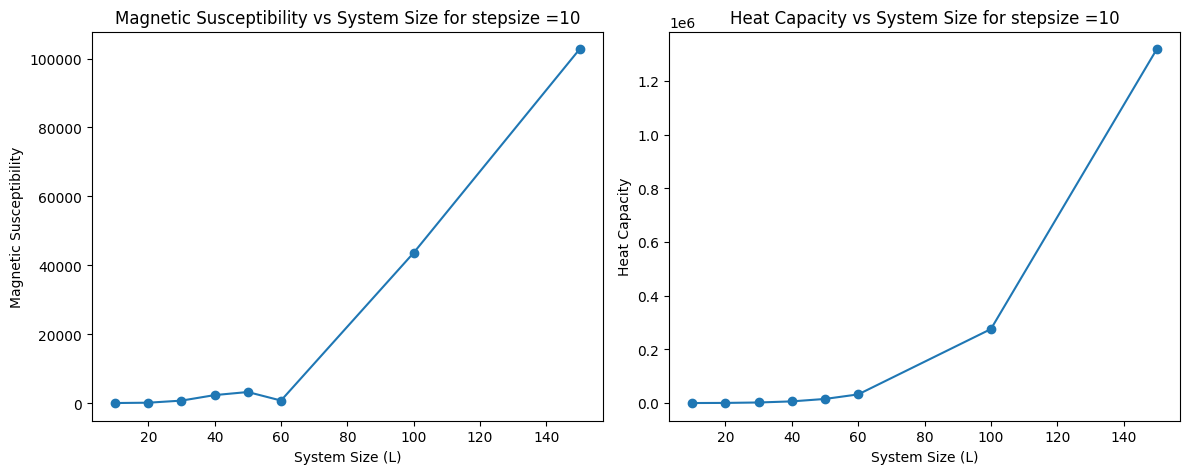

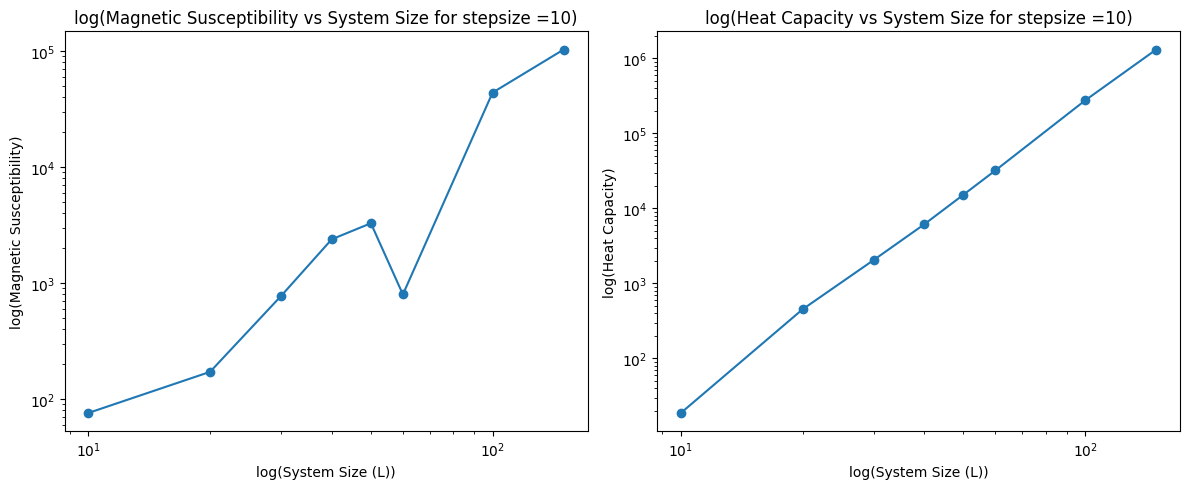

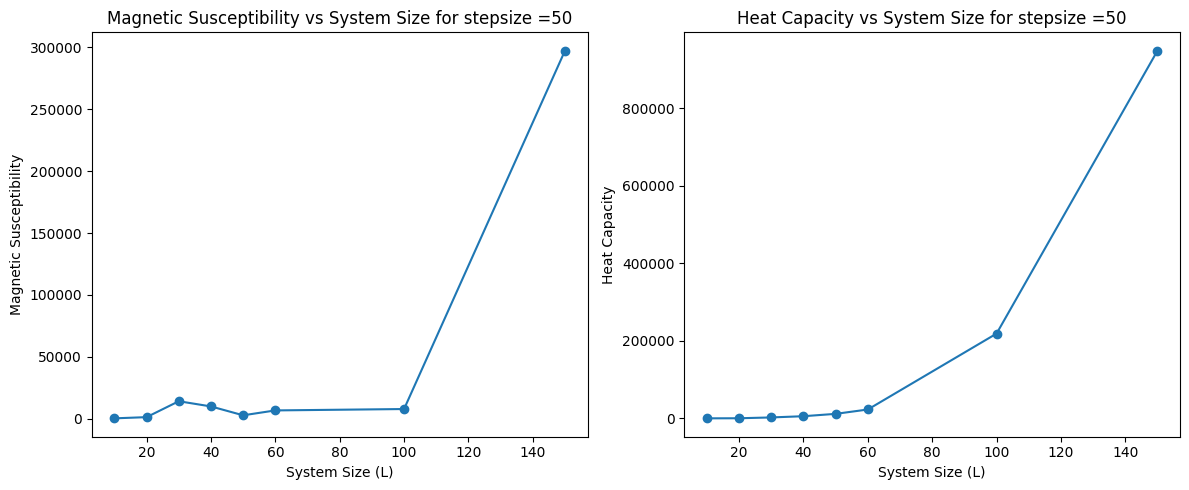

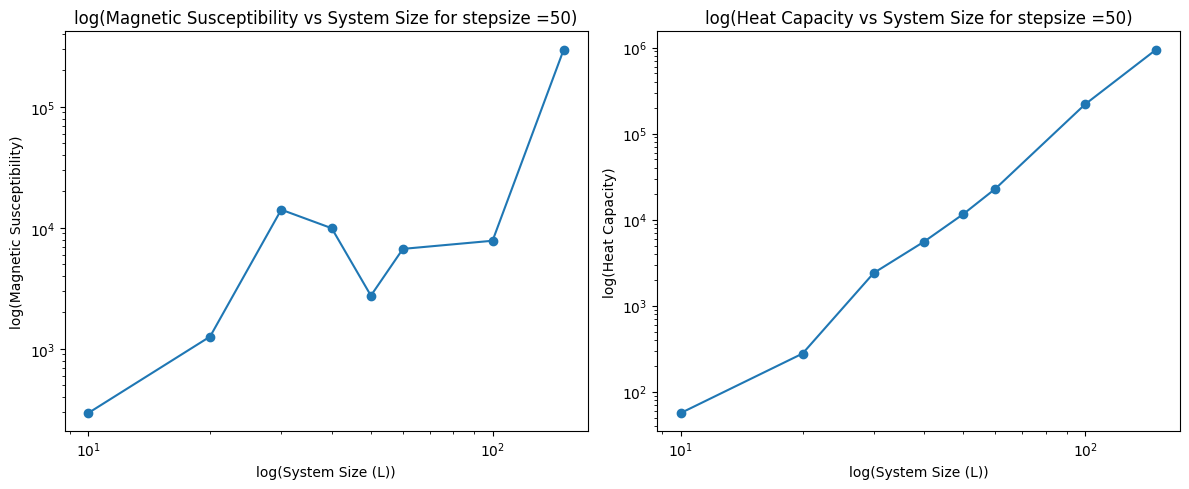

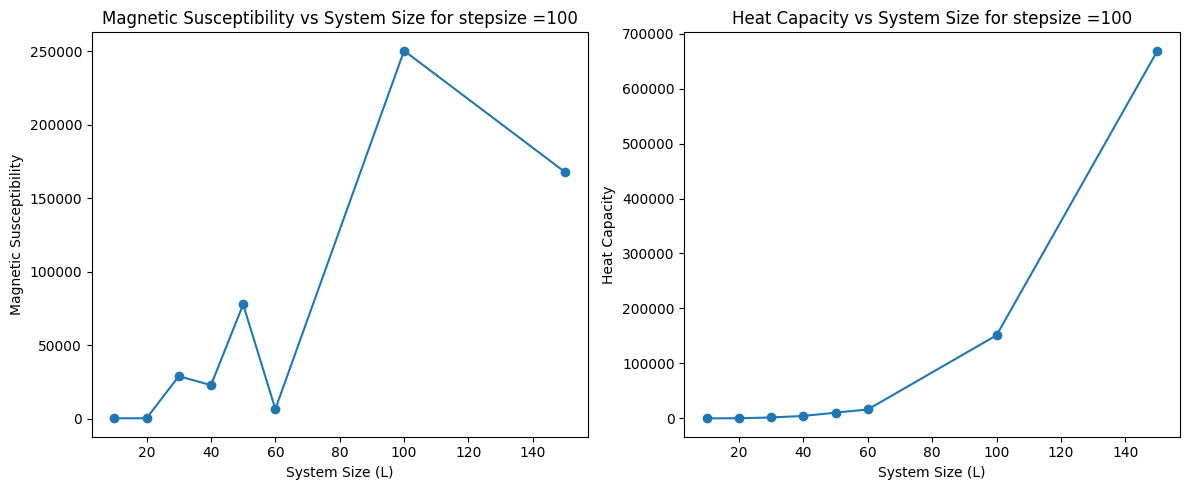

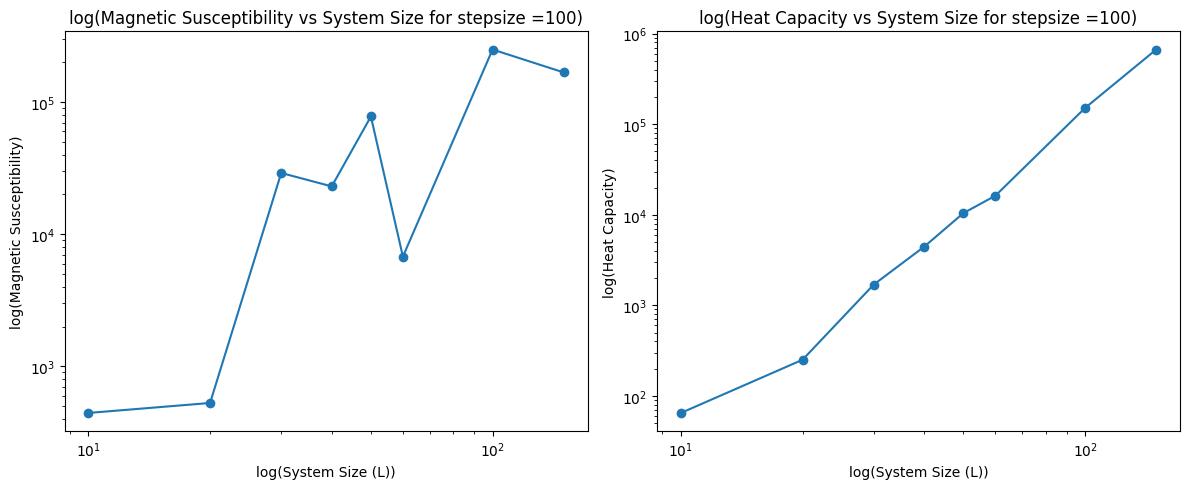

In [18]:
#Extract Critical Exponents
T_c_sus =crit_temps[2]      #take the T_c from the above calculations 

T_c_heat_cap =crit_temps[3]

T_c = (T_c_heat_cap + T_c_sus)/2

def plot_critical_exponents(T_c, L_values, steps):
    for steps in steps: 
        
        susceptibilities = []
        heat_capacities = []

        for L in L_values:
            model = IsingModel(L, T_c)
            
            energies, magnetizations = model.simulate(steps)
            susceptibility = np.var(magnetizations) /  T_c
            heat_capacity = np.var(energies) / ( T_c**2)
            susceptibilities.append(susceptibility)
            heat_capacities.append(heat_capacity)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(L_values, susceptibilities, 'o-')
        plt.title(f'Magnetic Susceptibility vs System Size for stepsize ={steps}')
        plt.xlabel('System Size (L)')
        plt.ylabel('Magnetic Susceptibility')

        plt.subplot(1, 2, 2)
        plt.plot(L_values, heat_capacities, 'o-')
        plt.title(f'Heat Capacity vs System Size for stepsize ={steps}')
        plt.xlabel('System Size (L)')
        plt.ylabel('Heat Capacity')

        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.loglog(L_values, susceptibilities, 'o-')
        plt.title(f'log(Magnetic Susceptibility vs System Size for stepsize ={steps})')
        plt.xlabel('log(System Size (L))')
        plt.ylabel('log(Magnetic Susceptibility)')

        plt.subplot(1, 2, 2)
        plt.loglog(L_values, heat_capacities, 'o-')
        plt.title(f'log(Heat Capacity vs System Size for stepsize ={steps})')
        plt.xlabel('log(System Size (L))')
        plt.ylabel('log(Heat Capacity)')

        plt.tight_layout()
        plt.show()

# Parameters
L_values = [10, 20, 30, 40, 50, 60, 100,150]
steps = [10, 50, 100]

plot_critical_exponents(T_c, L_values, steps)

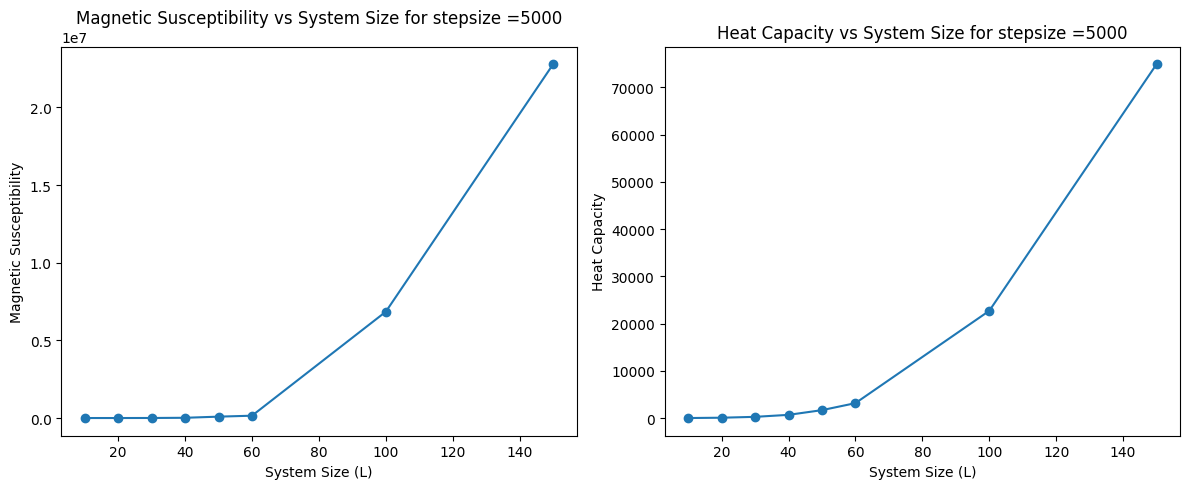

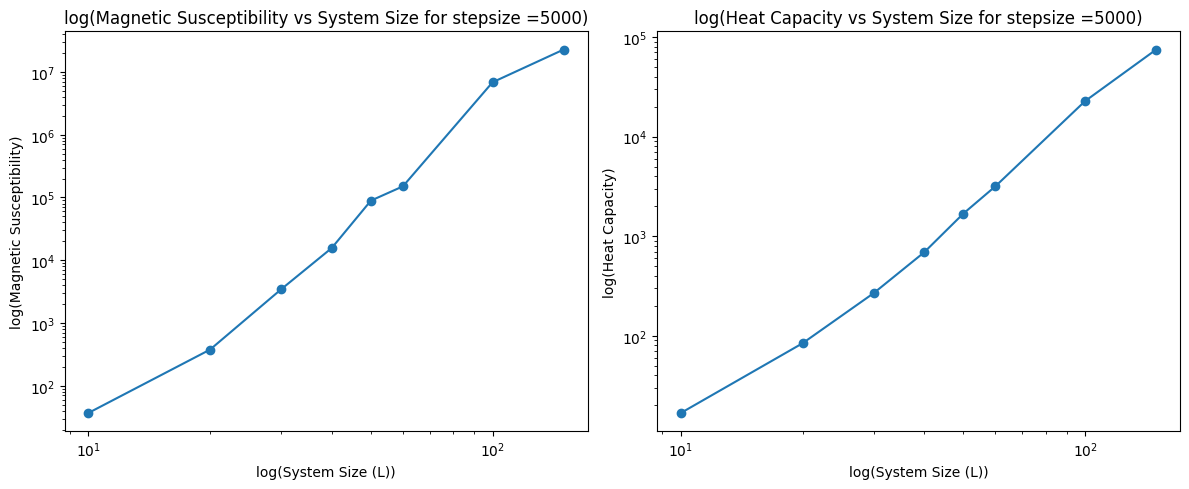

In [21]:
#Extract Critical Exponents
T_c_sus =crit_temps[2]      #take the T_c from the above calculations 

T_c_heat_cap =crit_temps[3]

T_c = (T_c_heat_cap + T_c_sus)/2

def plot_critical_exponents(T_c, L_values, steps):
    for steps in steps: 
        
        susceptibilities = []
        heat_capacities = []

        for L in L_values:
            model = IsingModel(L, T_c)
            
            energies, magnetizations = model.simulate(steps)
            susceptibility = np.var(magnetizations) /  T_c
            heat_capacity = np.var(energies) / ( T_c**2)
            susceptibilities.append(susceptibility)
            heat_capacities.append(heat_capacity)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(L_values, susceptibilities, 'o-')
        plt.title(f'Magnetic Susceptibility vs System Size for stepsize ={steps}')
        plt.xlabel('System Size (L)')
        plt.ylabel('Magnetic Susceptibility')

        plt.subplot(1, 2, 2)
        plt.plot(L_values, heat_capacities, 'o-')
        plt.title(f'Heat Capacity vs System Size for stepsize ={steps}')
        plt.xlabel('System Size (L)')
        plt.ylabel('Heat Capacity')

        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.loglog(L_values, susceptibilities, 'o-')
        plt.title(f'log(Magnetic Susceptibility vs System Size for stepsize ={steps})')
        plt.xlabel('log(System Size (L))')
        plt.ylabel('log(Magnetic Susceptibility)')

        plt.subplot(1, 2, 2)
        plt.loglog(L_values, heat_capacities, 'o-')
        plt.title(f'log(Heat Capacity vs System Size for stepsize ={steps})')
        plt.xlabel('log(System Size (L))')
        plt.ylabel('log(Heat Capacity)')

        plt.tight_layout()
        plt.show()

# Parameters
L_values = [10, 20, 30, 40, 50, 60, 100,150]

steps = [5000]

plot_critical_exponents(T_c, L_values, steps)